### Data & Imports

In [22]:
import pandas as pd

In [115]:
# Fogo_Competitor_Tripadvisor_file1 - additional brands
df = pd.read_csv("sample_reviews.csv")

In [24]:
df['reviews_id'] = df.index + 1

In [25]:
df.shape

(399106, 29)

In [26]:
df = df.sample(100)

In [27]:
reviews_df = df[['review_text','reviews_id']]

In [28]:
reviews_df

,review_text,reviews_id
107787,If you haven't yet tried the Wednesday Sirloin...,107788
232207,"Great fun, food and service. Sat in the bar to...",232208
216869,Steak cooked to perfection or they aim to plea...,216870
239936,We came here for dinner with friends. It was a...,239937
68994,"Great service, spectacular food and wonderful ...",68995
...,...,...
112505,Met with some friends here for dinner. Food wa...,112506
185363,Our server was Ashley and she was awesome! Too...,185364
328687,"Texas Roadhouse is a ""go to"" when traveling be...",328688
28035,I went there with a group of friends for NYE d...,28036


### Pre-Processing

In [29]:
## no preprocessing required unlike traditional NLP pipelines

In [30]:
import re

def clean_review(text):
    text = re.sub(r"<.*?>", "", text)  # remove HTML tags
    text = text.replace("\n", " ").strip()  # remove newlines
    return text


In [31]:
reviews_df['review_text'] = reviews_df['review_text'].apply(clean_review)

C:\Users\prjain\AppData\Local\Temp\ipykernel_28108\1605087330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['review_text'] = reviews_df['review_text'].apply(clean_review)


#### Truncate text

In [ ]:
# import tiktoken
# import json

# # Initialize tokenizer for gpt-4o-mini
# tokenizer = tiktoken.encoding_for_model("gpt-4o-mini")

# MAX_PROMPT_TOKENS = 2000  # Set max tokens for prompt (review + instructions)

# def truncate_text(text, max_tokens=MAX_PROMPT_TOKENS):
#     tokens = tokenizer.encode(text)
#     if len(tokens) > max_tokens:
#         tokens = tokens[:max_tokens]
#         return tokenizer.decode(tokens)
#     else:
#         return text

# # Truncate review_text if too long
# reviews_df['review_text'] = reviews_df['review_text'].apply(truncate_text)

#### not required since google already does that !! --- check & validate

C:\Users\prjain\AppData\Local\Temp\ipykernel_28108\291831986.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['review_text'] = reviews_df['review_text'].apply(truncate_text)


#### .jsonl Input File for Batch API

In [33]:
batch_input_path = "batchinput.jsonl"

system_prompt = (
    "You are a helpful assistant that analyzes customer reviews. "
    "For each review, return the sentiment (Positive, Neutral, or Negative) "
    "and a short topic label (1-5 words) in this JSON format:\n"
    '{"sentiment": "...", "topic": "..."}'
)

with open(batch_input_path, "w", encoding="utf-8") as f:
    for idx, row in reviews_df.iterrows():
        request_body = {
            "custom_id": str(row["reviews_id"]),  # or another unique ID
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": "gpt-4o-mini",
                "messages": [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": f"Review: {row['review_text']}"}
                ],
                "max_tokens": 100,
                "temperature": 0.0  # deterministic output
            }
        }
        f.write(json.dumps(request_body) + "\n")

print(f"Batch input saved to {batch_input_path}")


Batch input saved to batchinput.jsonl


### Upload Batch

In [34]:
from openai import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()
openai = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

upload_response = openai.files.create(
    file=open(batch_input_path, "rb"),
    purpose="batch",
)

input_file_id = upload_response.id
print(f"Uploaded batch input file with id: {input_file_id}")

Uploaded batch input file with id: file-7nDEo4Sx9Xr1rmMtqTiub2


### Create batch job

In [35]:
batch_response = openai.batches.create(
    input_file_id=input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
)

batch_id = batch_response.id
print(f"Created batch job with id: {batch_id}")

Created batch job with id: batch_6876675a71fc8190b0e29ed07474c9a3


### Poll/Download/Merge batch

In [38]:
import time

# Step 4: Poll batch status until completed
status = batch_response.status
print(f"Initial batch status: {status}")

while status not in ["completed", "failed", "cancelled", "expired"]:
    time.sleep(10)  # wait 10 seconds between polls
    batch_response = openai.batches.retrieve(batch_id)
    status = batch_response.status
    print(f"Polled batch status: {status}")

if status == "completed":
    output_file_id = batch_response.output_file_id
    print(f"Batch completed! Output file id: {output_file_id}")

    # Step 5: Download batch output file
    output_file_response = openai.files.content(output_file_id)
    output_lines = output_file_response.text.splitlines()

    # Save output locally
    output_path = "batch_output.jsonl"
    with open(output_path, "w", encoding="utf-8") as out_f:
        for line in output_lines:
            out_f.write(line + "\n")

    print(f"Batch output saved to {output_path}")

    # Step 6: Build results_map from batch output
    results_map = {}
    for line in output_lines:
        result = json.loads(line)
        cid = result.get("custom_id")
        response_body = result.get("response", {}).get("body", {})
        choices = response_body.get("choices", [])
        if choices:
            content = choices[0]["message"]["content"]
            try:
                parsed_content = json.loads(content)  # parse GPT's JSON response
            except json.JSONDecodeError:
                parsed_content = {"error": "Invalid JSON response", "raw_content": content}
            results_map[cid] = parsed_content
        else:
            results_map[cid] = {"error": "No valid response"}

    # Initialize columns with default None
    reviews_df['sentiment'] = None
    reviews_df['topic'] = None

    # Update DataFrame with results
    for cid, result in results_map.items():
        sentiment = result.get('sentiment')
        topic = result.get('topic')
        reviews_df.loc[reviews_df['reviews_id'].astype(str) == cid, 'sentiment'] = sentiment
        reviews_df.loc[reviews_df['reviews_id'].astype(str) == cid, 'topic'] = topic

    # Optional: print updated rows
    print(reviews_df[['reviews_id', 'sentiment', 'topic']].head())

else:
    print(f"Batch ended with status: {status}. Check batch logs for errors.")


Initial batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled batch status: in_progress
Polled ba

C:\Users\prjain\AppData\Local\Temp\ipykernel_28108\2965386027.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['sentiment'] = None
C:\Users\prjain\AppData\Local\Temp\ipykernel_28108\2965386027.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['topic'] = None


### Post Processing

In [40]:
reviews_df['topic'].value_counts()

topic
Great food and service             8
Food quality and service           8
Service and Food Quality           5
Birthday celebration experience    4
Great steak experience             3
                                  ..
Great dining experience            1
Poor experience and value          1
Good service and food              1
Mixed dining experience            1
Great Italian food                 1
Name: count, Length: 71, dtype: int64

In [ ]:
# output shows lot of similar but slightly different topics like Great food and service, Food quality and service etc
# they should come under same category as they express same idea

# 1. we can use fuzzy match and groups topics with ~90% text similarity into the same label -- xx
# 2. choose topic from predefined list of topics [Food, Service, Price, Ambiance, Special Occasions...]
    # - process sample 1000 rows  to extract representative topic labels > create clean predefined list of topics from them > use that list for complete dataset
# 3. Use OpenAI embeddings (text-embedding-3-small) to convert topics to vectors and group them using clustering (KMeans or DBSCAN)

#### Option#2

1. Process a sample of 1,000 reviews initially.
2. Extract key topics and abstract themes from this sample, and incorporate any additional themes provided by stakeholders.
3. Use the finalized list of themes to analyze the entire dataset.

In [ ]:
#group similar topics

from fuzzywuzzy import fuzz, process
import pandas as pd

# Get unique, non-null topic list
topics = reviews_df['topic'].dropna().unique().tolist()

final_labels = []
topic_to_group = {}

for topic in topics:
    if not final_labels:
        # First topic becomes the first group
        final_labels.append(topic)
        topic_to_group[topic] = topic
        continue

    # Find closest match from existing groups
    result = process.extractOne(topic, final_labels, scorer=fuzz.token_sort_ratio)

    if result:
        best_match, score = result
        if score >= 90:
            topic_to_group[topic] = best_match
        else:
            final_labels.append(topic)
            topic_to_group[topic] = topic
    else:
        # No match found at all (very rare), treat as new group
        final_labels.append(topic)
        topic_to_group[topic] = topic

# Apply grouped topics
reviews_df['grouped_topic'] = reviews_df['topic'].map(topic_to_group)

C:\Users\prjain\AppData\Local\Temp\ipykernel_28108\1339890447.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['grouped_topic'] = reviews_df['topic'].map(topic_to_group)


In [53]:
reviews_df['grouped_topic'].value_counts()

grouped_topic
Food and Service Quality           17
Great food and service             10
Good food and service               4
Great steak experience              4
Birthday celebration experience     4
                                   ..
Best steakhouse experience          1
Great dining experience             1
Poor experience and value           1
Mixed dining experience             1
Great Italian food                  1
Name: count, Length: 62, dtype: int64

In [54]:
reviews_df['topic'].dropna().unique().tolist()

['Steak special and sides',
 'Fun dining experience',
 'Food and Service Quality',
 'Dining experience and food',
 'Service and Food Quality',
 'Great food and service',
 'Steaks and sides',
 'Family-friendly dining',
 'Food quality and service',
 'Excellent service and food',
 'Great meal and family-friendly',
 'Quality dinner experience',
 'Value and Service Quality',
 'Business group dining experience',
 'Good food and service',
 'Anniversary dinner experience',
 'Exceptional service and food',
 'Mixed experience at restaurant',
 'Busy lunch experience',
 'Great deals and food',
 'Food quality and atmosphere',
 'Great experience with family',
 'Great steak experience',
 'Poor service and food quality',
 'Poor service experience',
 'Poor service and atmosphere',
 'Filet quality and atmosphere',
 'Good steak and service',
 'Disappointing dining experience',
 'Consistent dining experience',
 'Poor food quality',
 'Favorite restaurant',
 'Great food and atmosphere',
 'Anniversary celebr

In [55]:
predefined_topics = ["Food Quality", "Dining Experience", "Service Quality", "Special Occasions", "Atmosphere", "Cuisine Type"]

In [59]:
# now we can use this list and run on complete dataset
# or use any other aspect/theme provided by requestor
# we can incorporate all in 1 go -- translation(require), sentiments, topic modelling
# max wait time - 24hr

In [ ]:
# predefined_topics = [
#     "Food Quality",
#     "Dining Experience",
#     "Service Quality",
#     "Special Occasions",
#     "Atmosphere",
#     "Cuisine Type",
#     "Other"
# ]

# system_prompt = (
#     "You are a helpful assistant that analyzes customer reviews. "
#     "For each review, return the sentiment (Positive, Neutral, or Negative) "
#     "and assign one topic from the following list:\n"
#     + ", ".join(predefined_topics) + "\n"
#     "Return the result in this exact JSON format:\n"
#     '{"sentiment": "...", "topic": "..."}\n'
#     "Make sure the 'topic' value is exactly one from the list above."
# )

In [60]:
# system_prompt = (
#     "You are a helpful assistant that analyzes customer reviews. "
#     "If the review is not in English, first translate it to English. "
#     "Then, for the English review, return the sentiment (Positive, Neutral, or Negative) "
#     "and assign one topic from the following list:\n"
#     + ", ".join(predefined_topics) + "\n"
#     "Return the result in this exact JSON format:\n"
#     '{"sentiment": "...", "topic": "..."}\n'
#     "Make sure the 'topic' value is exactly one from the list above."
# )


In [61]:
reviews_df

,review_text,reviews_id,sentiment,topic,grouped_topic
107787,If you haven't yet tried the Wednesday Sirloin...,107788,Positive,Steak special and sides,Steak special and sides
232207,"Great fun, food and service. Sat in the bar to...",232208,Positive,Fun dining experience,Fun dining experience
216869,Steak cooked to perfection or they aim to plea...,216870,Positive,Food and Service Quality,Food and Service Quality
239936,We came here for dinner with friends. It was a...,239937,Positive,Dining experience and food,Dining experience and food
68994,"Great service, spectacular food and wonderful ...",68995,Positive,Service and Food Quality,Food and Service Quality
...,...,...,...,...,...
112505,Met with some friends here for dinner. Food wa...,112506,Positive,Great food and service,Great food and service
185363,Our server was Ashley and she was awesome! Too...,185364,Positive,Great service and food,Great food and service
328687,"Texas Roadhouse is a ""go to"" when traveling be...",328688,Neutral,Mixed dining experience,Mixed dining experience
28035,I went there with a group of friends for NYE d...,28036,Positive,Service and Food Quality,Food and Service Quality


#### manually adding labels

In [63]:
from thefuzz import process

# Your predefined topics
predefined_topics = [
    "Food Quality",
    "Dining Experience",
    "Service Quality",
    "Special Occasions",
    "Atmosphere",
    "Cuisine Type",
    "Other"
]

def map_to_predefined_topic(topic, choices, threshold=70):
    """
    Map a topic string to the closest predefined topic based on fuzzy matching.
    Returns the matched topic if score >= threshold; otherwise returns 'Other'.
    """
    if not isinstance(topic, str) or topic.strip() == "":
        return "Other"
    
    match, score = process.extractOne(topic, choices)
    if score >= threshold:
        return match
    else:
        return "Other"

# Apply mapping to the existing 'topic' column (or 'grouped_topic' if preferred)
reviews_df['topic_label'] = reviews_df['topic'].apply(
    lambda x: map_to_predefined_topic(x, predefined_topics)
)

C:\Users\prjain\AppData\Local\Temp\ipykernel_28108\4179952073.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['topic_label'] = reviews_df['topic'].apply(


In [65]:
reviews_df[['review_text', 'sentiment', 'topic_label']].head(10)

,review_text,sentiment,topic_label
107787,If you haven't yet tried the Wednesday Sirloin...,Positive,Other
232207,"Great fun, food and service. Sat in the bar to...",Positive,Dining Experience
216869,Steak cooked to perfection or they aim to plea...,Positive,Service Quality
239936,We came here for dinner with friends. It was a...,Positive,Dining Experience
68994,"Great service, spectacular food and wonderful ...",Positive,Food Quality
253980,"In town for a speaking responsibility, headed ...",Positive,Food Quality
301967,We love their steaks and baked potato dinner. ...,Positive,Other
380471,"It is great for a romantic night out, or they ...",Positive,Other
128481,Friends and I stopped at the bonefish grill on...,Positive,Food Quality
116855,Texas Roadhouse has wonderful steaks and ribs!...,Positive,Food Quality


### Deep Dive Analysis

In [ ]:
# merged_df.sample(5)

,review_text_x,reviews_id,sentiment,topic_label,review_date,review_rating,username,source,scrape_date,excel_index,...,state,zipcode,latitude,longitude,country,source_address,avg_rating,scrape_date.1,year_month,sentiment_score
80,We went here on New Year's Eve early and got t...,3385,Positive,Food Quality,2016-01-03,4,booking745,Trip Advisor,7/9/2025,1480,...,GA,31601.0,30.841600,-83.327041,USA,"1874 Club House Dr, Valdosta, GA 31601",NaN,07/09/2025,2016-01,1
32,"I had the steak & shrimp, loaded bake potato &...",375675,Positive,Dining Experience,2020-01-21,5,18GaryF18,Trip Advisor,7/9/2025,1019,...,NC,27705.0,36.029061,-78.921345,USA,"1809 N. Pointe Drive, Durham, NC 27705",NaN,07/09/2025,2020-01,1
17,I have eaten at Bonefish in Camp Hilll numerou...,168959,Positive,Food Quality,2016-01-13,5,craigs999,Trip Advisor,7/9/2025,2731,...,PA,17011.0,40.225249,-76.934269,USA,"3505 Gettysburg Road, Camp Hill, PA 17011",NaN,07/09/2025,2016-01,1
4,"Great service, spectacular food and wonderful ...",68995,Positive,Food Quality,2025-02-14,5,A926JTfrankp,Trip Advisor,7/9/2025,2633,...,SC,29582.0,33.826161,-78.681801,USA,"103 Highway 17 S, North Myrtle Beach, SC 29582",NaN,07/09/2025,2025-02,1
73,We've never been disappointed with our ( limit...,29531,Positive,Dining Experience,2016-03-25,5,VetteMike,Trip Advisor,7/9/2025,2671,...,FL,34134.0,26.357118,-81.807156,USA,"26381 South Tamiami Trail, Bonita Springs, FL ...",NaN,07/09/2025,2016-03,1


In [134]:
# add support text  - relevant text from the review text based on topic label
# 5000 - 50000

<!-- #### sentiment distribution -->

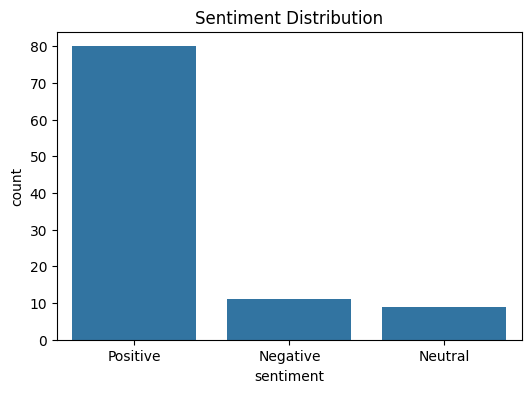

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(6,4))
# sns.countplot(data=reviews_df, x='sentiment', order=reviews_df['sentiment'].value_counts().index)
# plt.title("Sentiment Distribution")
# plt.show()


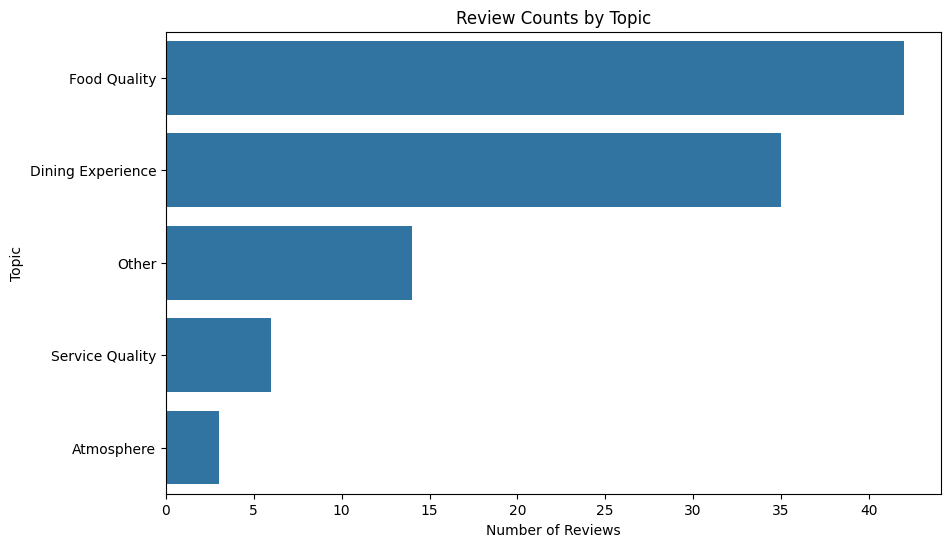

In [ ]:
# plt.figure(figsize=(10,6))
# order = reviews_df['topic_label'].value_counts().index
# sns.countplot(data=reviews_df, y='topic_label', order=order)
# plt.title("Review Counts by Topic")
# plt.xlabel("Number of Reviews")
# plt.ylabel("Topic")
# plt.show()


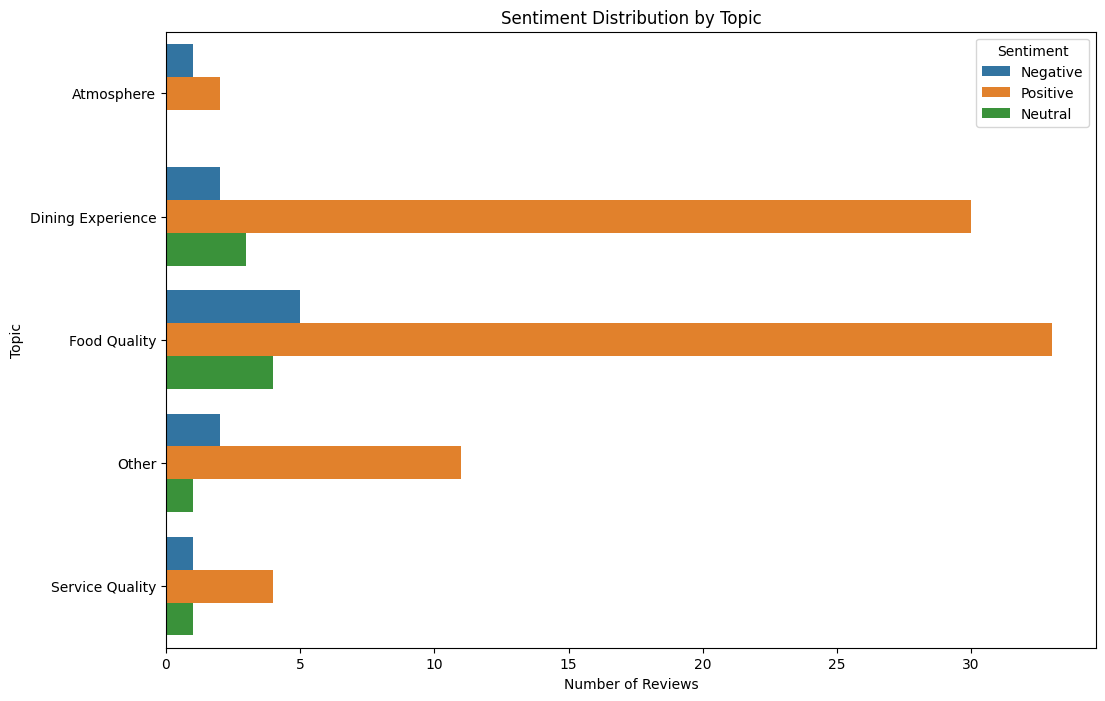

In [ ]:
# plt.figure(figsize=(12,8))
# topic_sentiment = reviews_df.groupby(['topic_label', 'sentiment']).size().reset_index(name='counts')
# sns.barplot(data=topic_sentiment, y='topic_label', x='counts', hue='sentiment')
# plt.title("Sentiment Distribution by Topic")
# plt.xlabel("Number of Reviews")
# plt.ylabel("Topic")
# plt.legend(title='Sentiment')
# plt.show()


#### word cloud

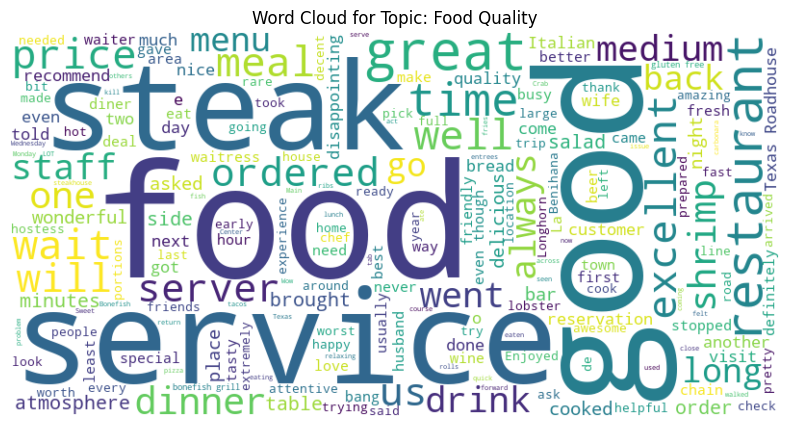

In [ ]:
# from wordcloud import WordCloud

# topic = "Food Quality"
# text = " ".join(reviews_df[reviews_df['topic_label'] == topic]['review_text'].tolist())

# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# plt.figure(figsize=(10,5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.title(f"Word Cloud for Topic: {topic}")
# plt.show()


#### reviews per topic for each sentiment

In [ ]:
# merged_df['topic_label'].value_counts()

topic_label
Food Quality         42
Dining Experience    35
Other                14
Service Quality       6
Atmosphere            3
Name: count, dtype: int64

In [ ]:
# def sample_reviews_func(x):
#     n = 5
#     if len(x) < n:
#         # just return all reviews without duplicates
#         return x
#     else:
#         # sample without replacement
#         return x.sample(n, random_state=hash(x.name) % (2**32))


# sample_reviews_per_topic = merged_df.groupby('topic_label').apply(sample_reviews_func).reset_index(drop=True)

# # Print as before
# for topic, group in sample_reviews_per_topic.groupby('topic_label'):
#     print(f"\nTopic: {topic}")
    
#     positive_reviews = group[group['sentiment_score'] > 0]['review_text_x']
#     negative_reviews = group[group['sentiment_score'] < 0]['review_text_x']
    
#     print("\nPositive Reviews:")
#     for review in positive_reviews:
#         print(f"- {review}\n")
    
#     print("Negative Reviews:")
#     for review in negative_reviews:
#         print(f"- {review}\n")
    
#     print("-" * 60)



Topic: Atmosphere

Positive Reviews:
- I'm a self-appointed filet snob and have to hand it to these guys, they do a very, very good job on a filet. Not quite up to Firebirds, but not up to their prices either, definitely worth going. Their loaded baked potato is award winning, and it's hard not to fill right up on the complimentary rolls & butter and in-shell peanuts. Neat log cabin style atmosphere, though certainly not the place I'd come for a special occasion, imho, just a little too, I dunno, Kmart-ish if that makes any sense.

- We are typically not chain restaurant people. But we always make an exception for the Bonefish.  While Bang Bang shrimp is the go to appetizer we always have them make their original "saucy shrimp" for us. Amazing. Try it!!   Love sitting in the bar area and conversing with other patrons. Their drinks are very well made and we always have a delicious, consistently well prepared meal here.

Negative Reviews:
- My wife and i went with two friends. The atmos

C:\Users\prjain\AppData\Local\Temp\ipykernel_28108\3034589857.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_reviews_per_topic = merged_df.groupby('topic_label').apply(sample_reviews_func).reset_index(drop=True)


#### Trend

In [ ]:
# #concat all other rows
merged_df = reviews_df.merge(df, on='reviews_id',how='left')

In [ ]:
merged_df.drop(columns=['topic', 'grouped_topic','review_text_y','review_heading','language','review_ID',], inplace=True)

In [ ]:
merged_df['review_date'] = pd.to_datetime(merged_df['review_date'])

In [ ]:
# Create a new column for year-month
merged_df['year_month'] = merged_df['review_date'].dt.to_period('M')

# Group by year_month and sentiment, count reviews
sentiment_time = merged_df.groupby(['year_month', 'sentiment']).size().reset_index(name='count')

In [ ]:
sentiment_pivot = sentiment_time.pivot(index='year_month', columns='sentiment', values='count').fillna(0)

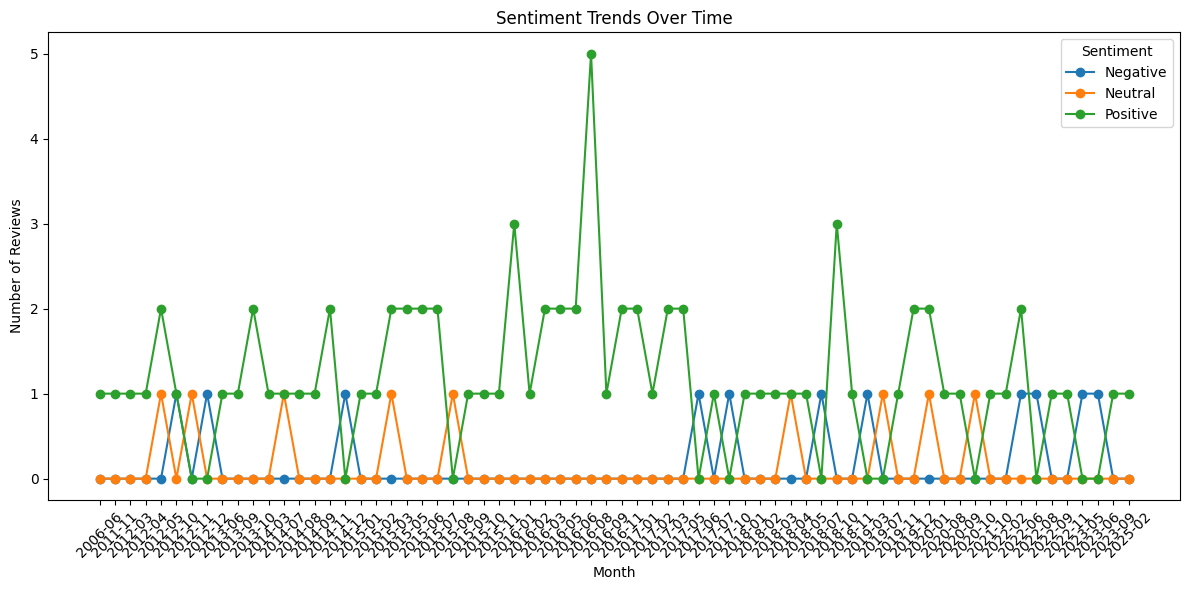

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for sentiment in sentiment_pivot.columns:
    plt.plot(sentiment_pivot.index.astype(str), sentiment_pivot[sentiment], marker='o', label=sentiment)

plt.title('Sentiment Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


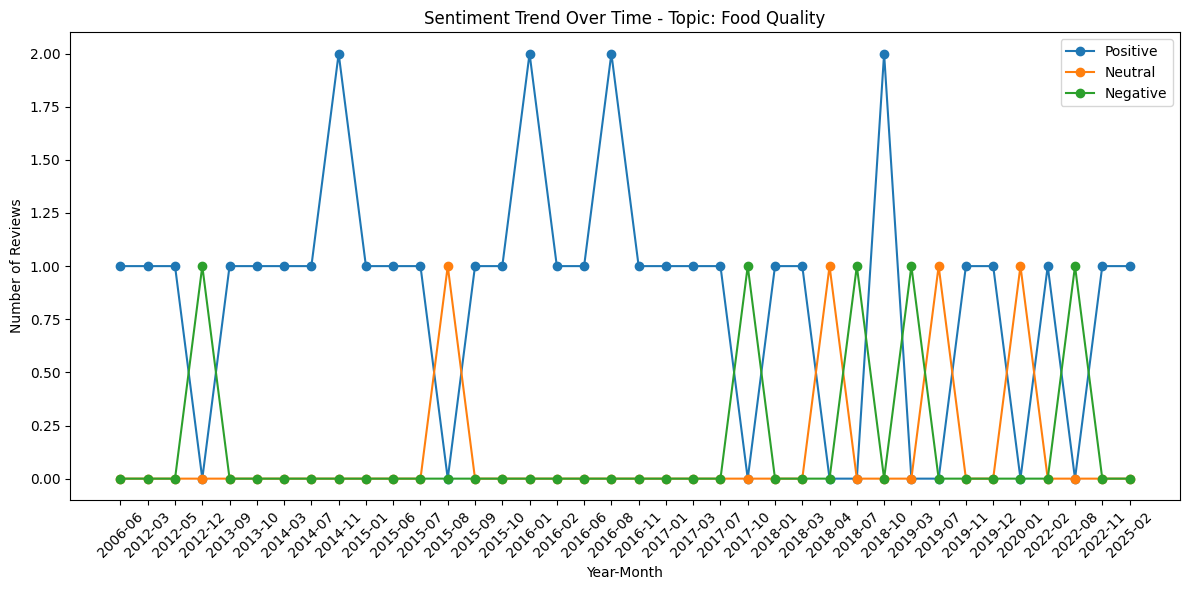

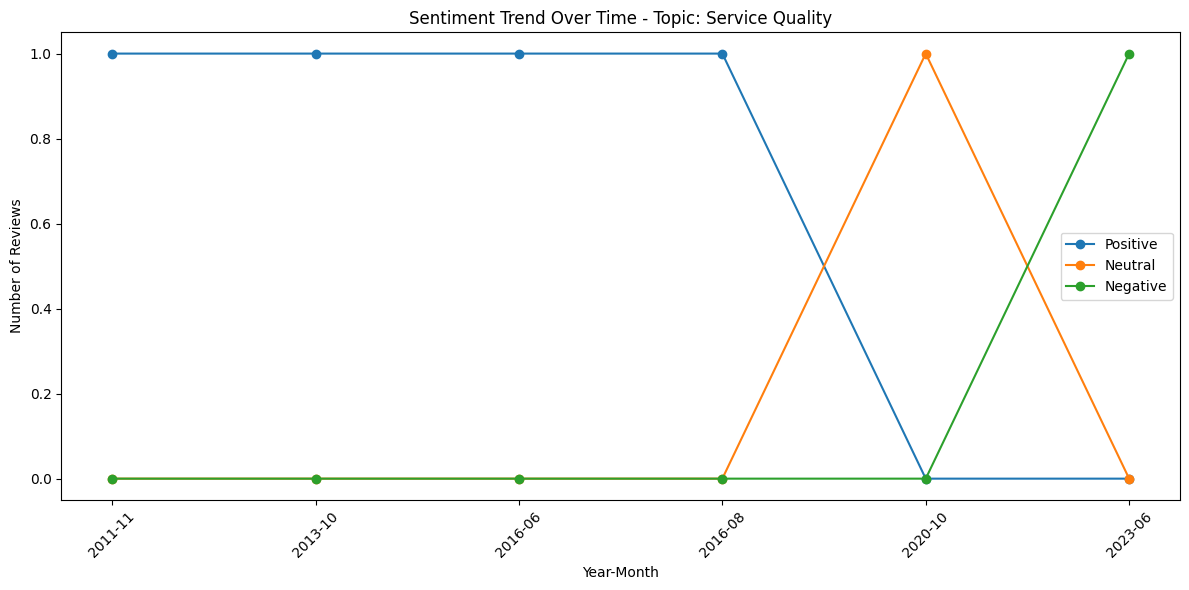

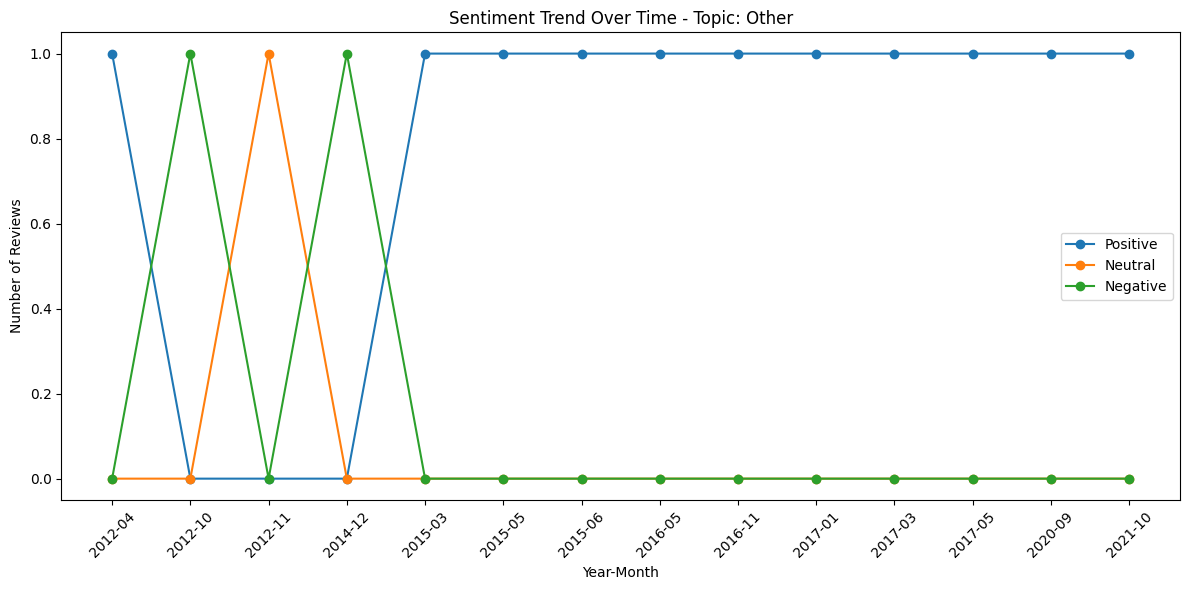

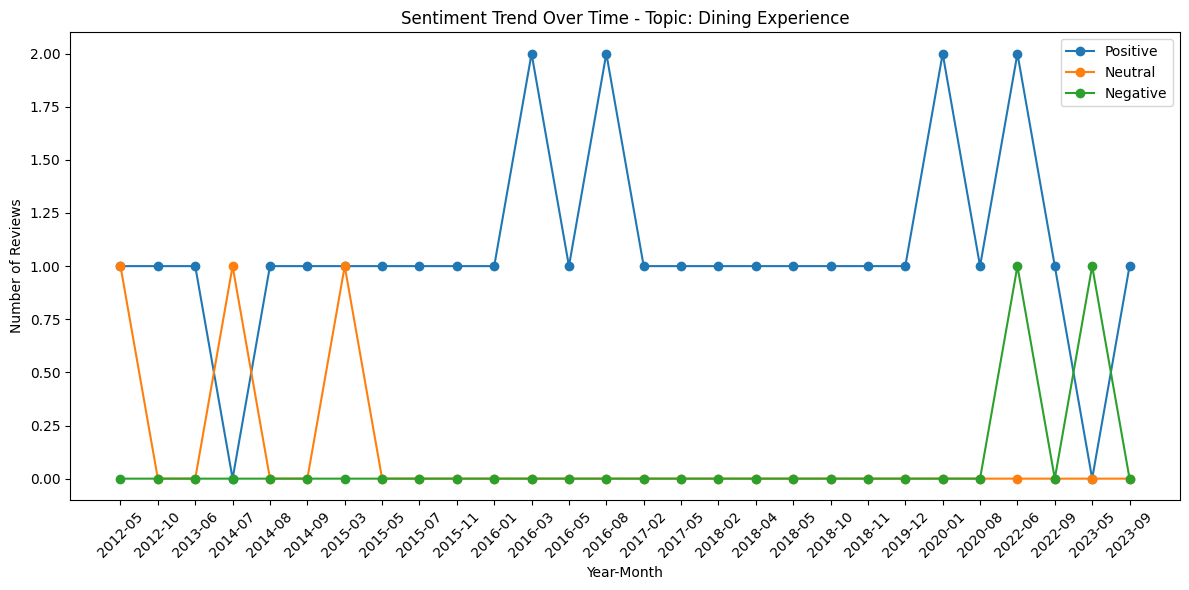

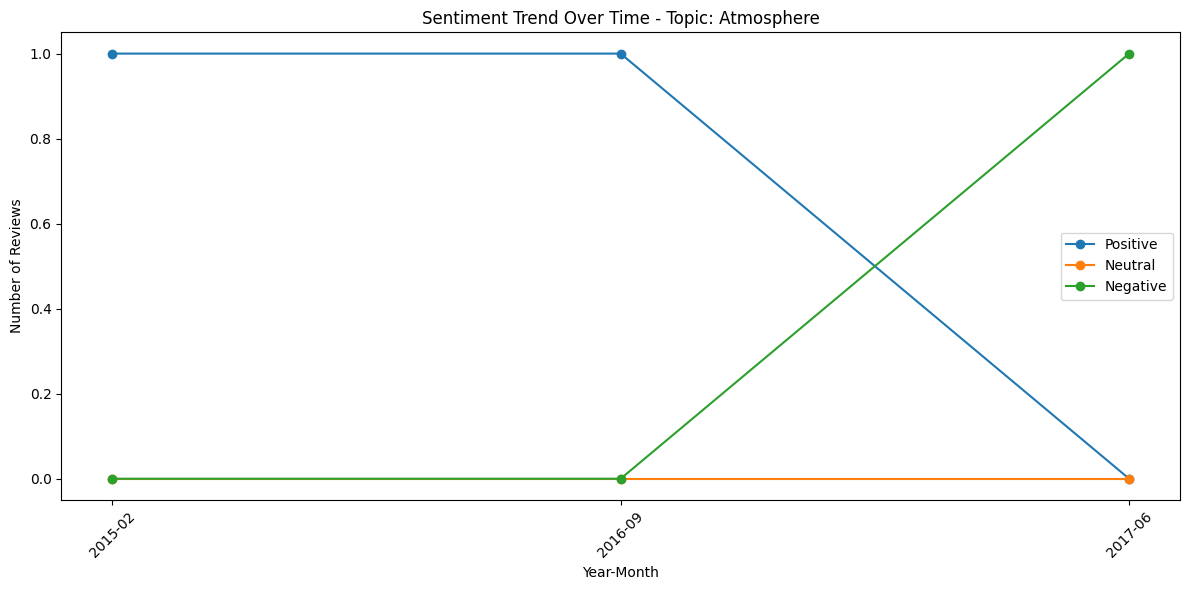

In [ ]:
# Group by year_month, topic_label, and sentiment
grouped = (
    merged_df.groupby(['year_month', 'topic_label', 'sentiment'])
    .size()
    .reset_index(name='count')
)

# Pivot table so sentiment becomes columns
pivot_df = grouped.pivot_table(
    index=['year_month', 'topic_label'],
    columns='sentiment',
    values='count',
    fill_value=0
).reset_index()

#all topics
unique_topics = pivot_df['topic_label'].unique()

for topic in unique_topics:
    df_topic = pivot_df[pivot_df['topic_label'] == topic]
    
    plt.figure(figsize=(12, 6))
    for sentiment in ['Positive', 'Neutral', 'Negative']:
        if sentiment in df_topic.columns:
            plt.plot(df_topic['year_month'].astype(str), df_topic[sentiment], marker='o', label=sentiment)
    
    plt.title(f"Sentiment Trend Over Time - Topic: {topic}")
    plt.xlabel("Year-Month")
    plt.ylabel("Number of Reviews")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
merged_df.to_csv("sample_reviews_processed.csv", index=False, encoding="utf-8-sig")

<!-- #### What else? -->

In [ ]:
# Sentiment by source
# Topic frequency distribution
# Topic heatmap 
# Review volume over time
# Average rating over time
# Seasonality in reviews
# Reviews per state/city
# Sentiment by region
# Most active reviewers
# Sentiment/ Topic trends by location
# Rating distribution (1-5)
# Correlation between rating and sentiment
# Word clouds per sentiment
# Analyze negative reviews by location or topic

### Validation: Correlation between review_rating and sentiment

In [107]:
sentiment_map = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}

merged_df['sentiment_score'] = merged_df['sentiment'].map(sentiment_map)


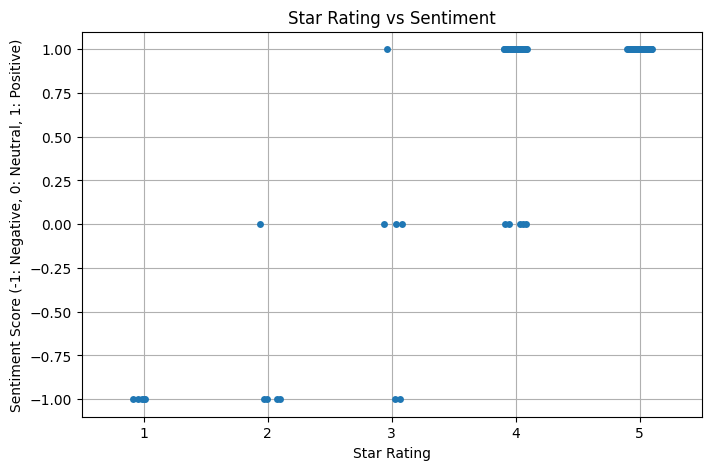

In [108]:
plt.figure(figsize=(8, 5))
sns.stripplot(data=merged_df, x='review_rating', y='sentiment_score', jitter=True)
plt.title("Star Rating vs Sentiment")
plt.xlabel("Star Rating")
plt.ylabel("Sentiment Score (-1: Negative, 0: Neutral, 1: Positive)")
plt.grid(True)
plt.show()


In [110]:
merged_df[['review_rating', 'sentiment_score']].corr().iloc[0,1]

np.float64(0.849124855853433)

In [111]:
#strong positive

<!-- ### How -->

In [ ]:
# 1. Process a sample of 1,000 reviews initially.
# 2. Extract key topics and themes from this sample, and incorporate any additional themes provided by requestor.
# 3. Use the finalized list of themes and categorize the entire dataset into those themes
# 4. Perform deep dive analysis: sentiment, topic trends & any specifics

### Additional additions

In [135]:
# 1. add support text from review_text relevant to topic label
# 2. 5000 - 50000 batch api 

### Helper

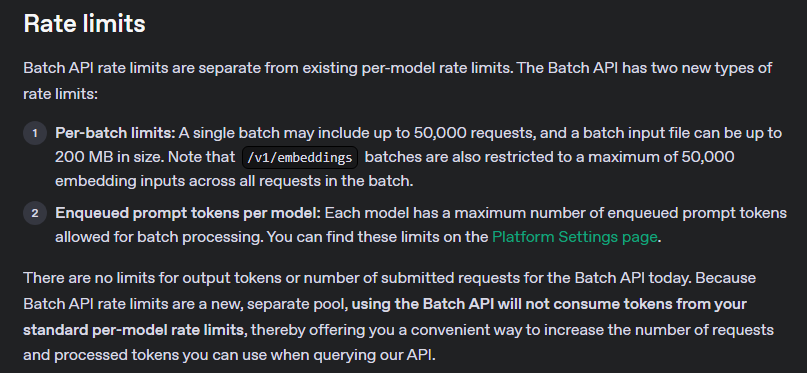

In [142]:
# 1000 sample & 5000 as total data

In [ ]:
# system_prompt = (
#     "You are a helpful assistant that analyzes customer reviews.\n"
#     "For each review:\n"
#     "- If the review is not in English, translate it to English first. If it's already in English, keep it as is.\n"
#     "- Use the English version of the review to:\n"
#     "  - Determine the sentiment (Positive, Neutral, or Negative).\n"
#     "  - Identify a short topic label (1–5 words).\n"
#     "  - Extract a short **exact phrase** (verbatim) from the English text that supports the topic.\n\n"
#     "Return your answer in this JSON format:\n"
#     '{"sentiment": "...", "topic": "...", "support_text": "..."}'"
# )

In [137]:
# TOPIC_LIST = [
#     "Food Quality", "Service", "Ambience", "Pricing", "Cleanliness",
#     "Staff Attitude", "Menu Variety", "Wait Time", "Value for Money", "Portion Size"
# ]

# system_prompt = (
#     "You are a helpful assistant that analyzes customer reviews.\n\n"
#     "For each review:\n"
#     "1. Select **one** topic label from this list that best fits the main theme of the review:\n"
#     f"{TOPIC_LIST}\n"
#     "2. Determine the sentiment (Positive, Neutral, or Negative).\n"
#     "3. Extract a short **exact phrase from the review** that best supports the selected topic.\n\n"
#     "Output your answer in this JSON format:\n"
#     '{"topic": "...", "sentiment": "...", "support_text": "..."}\n\n"
#     "The `support_text` must be a **verbatim quote** from the review."
# )


In [138]:
# # Split your data into batches (if needed)
# import pandas as pd
# import math

# def split_into_batches(df, batch_size=50000):
#     num_batches = math.ceil(len(df) / batch_size)
#     for i in range(num_batches):
#         batch = df.iloc[i*batch_size : (i+1)*batch_size]
#         batch.to_json(f'batch_{i+1}.jsonl', orient='records', lines=True)


#Monitor token usage (optional but good practice)
# import tiktoken

# encoding = tiktoken.encoding_for_model("gpt-4-turbo")
# def count_tokens(text):
#     return len(encoding.encode(text))

# df["tokens"] = df["review_text"].apply(count_tokens)
# print(f"Estimated total tokens in batch: {df['tokens'].sum()}")


# Submit each batch using OpenAI Batch API
# openai batch create \
#   -i batch_1.jsonl \
#   -t completion \
#   -m gpt-4-turbo \
#   --completion_window 24h \
#   --metadata name="review_sentiment_batch_1"

# You can script this loop in Python using subprocess or automate submission via API calls.
# Avoid concurrency overload (optional) -- If submitting batches in parallel, you might want to add a sleep delay or queue jobs to avoid overloading the batch queue, especially if your org limit is low.


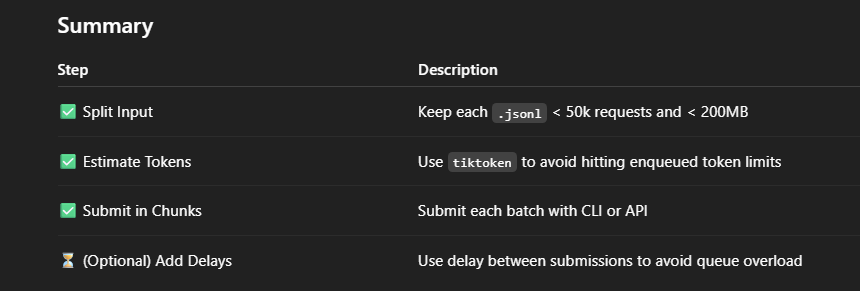